# 다음에 볼 영화 예측하기

## 평가 루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

평가문항	상세기준
1. Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다. : 데이터셋의 면밀한 분석을 토대로 세션단위 정의 과정(길이분석, 시간분석)을 합리적으로 수행한 과정이 기술되었다.
2. RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다. : 적절한 epoch만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선되는 것이 확인된다.
3. 세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다. : 3가지 이상의 변화를 시도하고 그 실험결과를 체계적으로 분석하였다.

# 프로젝트 - Movielens 영화 SBR
- 이번에도 우리는 Movielens 1M Dataset을 기반으로, Session based Recommendation 시스템을 제작해 보겠습니다.

## 데이터 특성

- 여기서 이전 실습내역과 가장 크게 다른 부분은 바로 SessionID 대신 UserID 항목이 들어갔다는 점입니다. 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다. 그래서 이번에는 UserID가 SessionID 역할을 해야 합니다.

- Rating 정보가 포함되어 있습니다. 이전 실습내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있습니다. 하지만, 직전에 봤던 영화가 맘에 들었는지 여부가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.

- Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초단위 시간이 기재되어 있습니다.

위와 같은 정보를 바탕으로 오늘의 실습과정과 유사한 프로젝트 과정을 진행해 보겠습니다.

# Step 1. 데이터의 전처리
- 위와 같이 간단히 구성해 본 데이터셋을 꼼꼼이 살펴보면서 항목별 기본분석, session length, session time, cleaning 등의 작업을 진행합니다.
- 특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.



In [1138]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [1139]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose-data/ml-1m') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

In [1140]:
data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


- 추천시스템을 구축할 때 가장 먼저 확인해 볼 것은 유저수(세션 수)와 아이템 수 입니다.

In [1141]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

- 사용자의 숫자가 6040개, 아이템 숫자는 3706개가 됩니다.

## User Rating Count
- 각 사용자가 대략 몇 개의 Rating 데이터를 갖는지도 살펴보겠습니다.

In [1142]:
user_rating_cnt = data.groupby('UserId').size()
user_rating_cnt

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [1143]:
time_rating_cnt = data.groupby('Time').size()
time_rating_cnt

Time
956703932     1
956703954     2
956703977     2
956704056     5
956704081     1
             ..
1046454320    1
1046454338    1
1046454443    1
1046454548    2
1046454590    1
Length: 458455, dtype: int64

In [1144]:
user_time_rating_cnt = data.groupby(['UserId', 'Time']).size()
user_time_rating_cnt

UserId  Time     
1       978300019    1
        978300055    3
        978300103    1
        978300172    1
        978300275    1
                    ..
6040    997454398    1
        997454429    1
        997454464    2
        997454486    1
        998315055    1
Length: 471163, dtype: int64

In [1145]:
rating_cnt = data.groupby('Rating').size()
rating_cnt

Rating
1     56174
2    107557
3    261197
4    348971
5    226310
dtype: int64

In [1146]:
user_rating_cnt = data.groupby(['UserId', 'Rating']).size()
user_rating_cnt

UserId  Rating
1       3           8
        4          27
        5          18
2       1           2
        2          11
                 ... 
6040    1          27
        2          38
        3          63
        4         137
        5          76
Length: 28370, dtype: int64

- 여기서 user_rating_cnt란 같은 유저 구분자인 UserId를 공유하는 데이터 row의 개수를 의미합니다. 
- 따라서 여기서 user_rating_cnt란 해당 사용자가 몇번의 Rating 액션을 취했는지(몇개의 평점을 매겼는지)의 의미가 됩니다.

In [1147]:
time_rating_cnt.median(), time_rating_cnt.mean()

(2.0, 2.181695040952765)

In [1148]:
user_rating_cnt.median(), user_rating_cnt.mean()

(16.0, 35.25586887557279)

In [1149]:
user_time_rating_cnt.median(), user_time_rating_cnt.mean()

(2.0, 2.1228513274599234)

In [1150]:
rating_cnt.median(), rating_cnt.mean()

(226310.0, 200041.8)

In [1151]:
user_rating_cnt.median(), user_rating_cnt.mean()

(16.0, 35.25586887557279)

In [1152]:
time_rating_cnt.min(), time_rating_cnt.max()

(1, 30)

In [1153]:
user_rating_cnt.min(), user_rating_cnt.max()

(1, 945)

In [1154]:
user_time_rating_cnt.min(), user_time_rating_cnt.max()

(1, 30)

In [1155]:
rating_cnt.min(), rating_cnt.max()

(56174, 348971)

In [1156]:
user_rating_cnt.min(), user_rating_cnt.max()

(1, 945)

- 사용자별 시간(초)별 Rating 갯수는 보통 2개 정도입니다.
- 근데, 같은 시간(초)에 30개 이상 Rating 갯수가 있다는 것은 뭔가 이상합니다.

In [1157]:
time_rating_cnt.quantile(0.999)

12.0

In [1158]:
user_rating_cnt.quantile(0.999)

451.63100000000486

In [1159]:
user_time_rating_cnt.quantile(0.999)

10.0

In [1160]:
rating_cnt.quantile(0.999)

348619.90400000004

In [1161]:
max_user_time_rating_cnt

(731, 975528402)

- 동일한 시간에, 또는 매우 짧은 간격으로 지속적으로 Rating을 해오고 있습니다. 
- 시각 시간과 끝 시간의 간격은 (1024176337 - 965333392) % 60 % 60 % 24 % 30 = 22.7 개월간 입니다.
- 마지막 5개의 Rating은 (1024176337 - 1024174347) % 60 = 33.1 분 동안 이루어졌습니다. 
- 유저들의 서비스 이용행태는 다양하기 때문에 데이터 전처리를 어떻게 할지는 모델을 만드는 사람이 판단해야 합니다.
    - e.g.) 어떤 영화의 경우 33분 내에 1명이 5개의 평점을 주고 나갔다면 이 영화의 평점을 주면 혜택을 주는 이벤트에 참여하기 위해 조작하고 있는 건 아닐까요?

- 동일한 시간(초)에, 또는 매우 짧은 간격으로 지속적으로 Rating을 해오고 있습니다. 
- 같은 사용자가 동일한 시간(초)에 Rating 한 데이터는 삭제하도록 하겠습니다. 

In [1162]:
data=data.drop_duplicates(subset=['UserId', 'Time'], keep='first')
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
24,1,2340,3,978300103
36,1,1836,5,978300172
3,1,3408,4,978300275
...,...,...,...,...
999923,6040,232,5,997454398
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000167,6040,161,3,997454486


In [1163]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3600)

- 사용자별 Rating 갯수에 대한 감을 더 잘 파악하기 위해 시각화를 해보겠습니다.



In [1164]:
data['Datetime'] = pd.to_datetime('1970-01-01')
data['Datetime'] = pd.to_datetime(data['Datetime'], format="%Y-%m-%d %H:%M:%S")
data.dtypes

UserId               int32
ItemId               int32
Rating               int32
Time                 int64
Datetime    datetime64[ns]
dtype: object

In [1165]:
data

,UserId,ItemId,Rating,Time,Datetime
31,1,3186,4,978300019,1970-01-01
22,1,1270,5,978300055,1970-01-01
24,1,2340,3,978300103,1970-01-01
36,1,1836,5,978300172,1970-01-01
3,1,3408,4,978300275,1970-01-01
...,...,...,...,...,...
999923,6040,232,5,997454398,1970-01-01
1000019,6040,2917,4,997454429,1970-01-01
999988,6040,1921,4,997454464,1970-01-01
1000167,6040,161,3,997454486,1970-01-01


In [1166]:
data.Datetime = data.Datetime + data.Time.map(lambda x : dt.timedelta(seconds=x))

In [1167]:
data

,UserId,ItemId,Rating,Time,Datetime
31,1,3186,4,978300019,2000-12-31 22:00:19
22,1,1270,5,978300055,2000-12-31 22:00:55
24,1,2340,3,978300103,2000-12-31 22:01:43
36,1,1836,5,978300172,2000-12-31 22:02:52
3,1,3408,4,978300275,2000-12-31 22:04:35
...,...,...,...,...,...
999923,6040,232,5,997454398,2001-08-10 14:39:58
1000019,6040,2917,4,997454429,2001-08-10 14:40:29
999988,6040,1921,4,997454464,2001-08-10 14:41:04
1000167,6040,161,3,997454486,2001-08-10 14:41:26


- 한 사용자가 짧은 시간 내에 너무 많은 영화 평점을 준 데이터를 제거할 수도 있고 포함시킬 수도 있습니다. 
- 이 데이터에 대한 감을 더 잘 파악하기 위해 시각화를 해보겠습니다.

In [1168]:
user_rating_cnt = data.groupby('UserId').size()
user_rating_cnt

UserId
1        34
2        66
3        31
4         7
5        83
       ... 
6036    189
6037     56
6038     14
6039     46
6040    168
Length: 6040, dtype: int64

In [1169]:
user_rating_cumsum = user_rating_cnt.cumsum() / user_rating_cnt.sum()

In [1170]:
user_rating_cnt.cumsum()

UserId
1           34
2          100
3          131
4          138
5          221
         ...  
6036    470879
6037    470935
6038    470949
6039    470995
6040    471163
Length: 6040, dtype: int64

In [1171]:
user_rating_cnt.sum()

471163

In [1172]:
user_rating_cumsum

UserId
1       0.000072
2       0.000212
3       0.000278
4       0.000293
5       0.000469
          ...   
6036    0.999397
6037    0.999516
6038    0.999546
6039    0.999643
6040    1.000000
Length: 6040, dtype: float64

In [1173]:
user_rating_cumsum_999 = user_rating_cumsum[user_rating_cumsum < 0.999]

In [1174]:
user_rating_cumsum_999

UserId
1       0.000072
2       0.000212
3       0.000278
4       0.000293
5       0.000469
          ...   
6031    0.998578
6032    0.998686
6033    0.998729
6034    0.998737
6035    0.998996
Length: 6035, dtype: float64

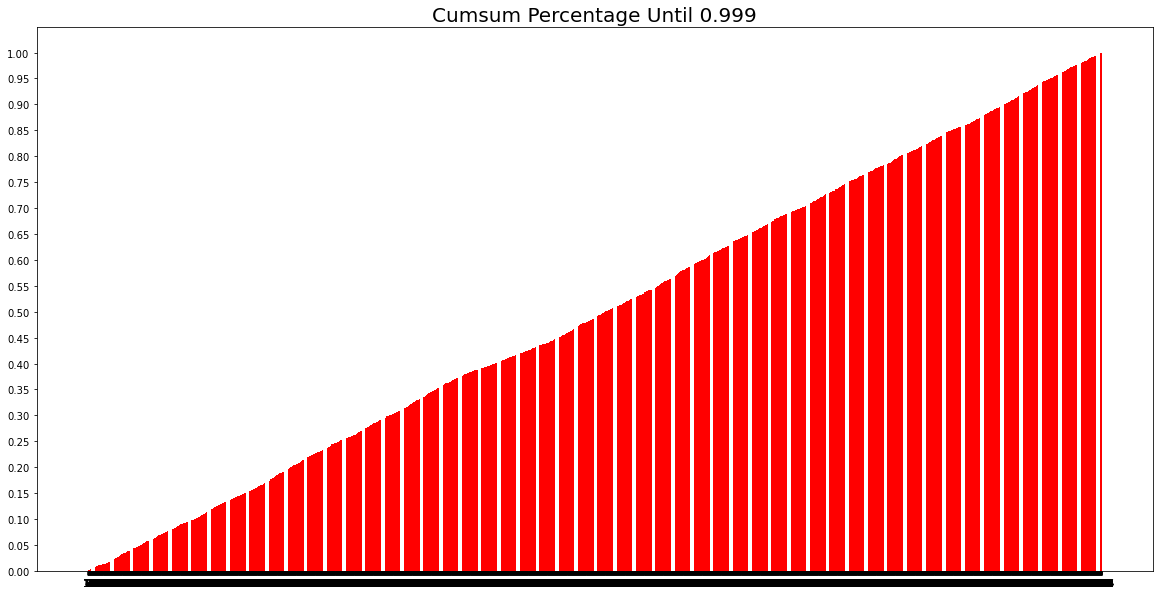

In [1111]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=user_rating_cumsum_999.index,
        height=user_rating_cumsum_999, color='red')
plt.xticks(user_rating_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

- 추천시스템은 유저-상품 관계 매트릭스를 유저 행렬과 상품 행렬의 곱으로 표현하는 Matrix Factorization 모델을 널리 사용합니다. 
- 그렇다면 이 데이터도 유저와 클릭한 상품정보 관계에 대해 Matrix Factorization을 사용하면 어떨까요? 
- User * Item Matrix의 빈칸이 너무 많아서(data sparsity) 모델이 제대로 학습되지 않을 가능성이 있습니다. 
- 이 세션정보는 유저를 ID 기반으로 정리할 수 없기 때문에 세션 하나를 유저 하나로 본다면 기존의 유저-상품정보 Matrix보다 훨씬 sparse한 형태가 됩니다.

## User Time

다루려는 데이터의 시간 관련 정보를 확인해 봅시다.

In [1175]:
oldest, latest = data['Datetime'].min(), data['Datetime'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


- 데이터는 설명대로 3년치 데이터가 있습니다.

In [1176]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

- latest는 Timestamp 객체이기 때문에 int 객체와의 사칙연산을 지원하지 않습니다.
- 날짜끼리의 차이를 구하고 싶을 때는 datetime 라이브러리의 timedelta 객체를 사용합니다.

In [1177]:
month_ago = latest - dt.timedelta(1040)     # 최종 날짜로부터 1040일 이전 날짜를 구한다.  
data = data[data['Datetime'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
data

,UserId,ItemId,Rating,Time,Datetime
31,1,3186,4,978300019,2000-12-31 22:00:19
22,1,1270,5,978300055,2000-12-31 22:00:55
24,1,2340,3,978300103,2000-12-31 22:01:43
36,1,1836,5,978300172,2000-12-31 22:02:52
3,1,3408,4,978300275,2000-12-31 22:04:35
...,...,...,...,...,...
999923,6040,232,5,997454398,2001-08-10 14:39:58
1000019,6040,2917,4,997454429,2001-08-10 14:40:29
999988,6040,1921,4,997454464,2001-08-10 14:41:04
1000167,6040,161,3,997454486,2001-08-10 14:41:26


## Data Cleansing
- Rating이 1인 경우도 꽤 있습니다. 
- 우리의 목적은 유저가 최소 Rating을 1 이상 주었을 때 선호도를 예측하는 것이므로 Rating이 1인 세션은 제거해줍니다.
- 두번째 실험에서는 Rating이 2인 세션도 제거해 주었습니다. 

In [1178]:
idx_rating = data[data['Rating']<3].index
data = data.drop(idx_rating)
data

,UserId,ItemId,Rating,Time,Datetime
31,1,3186,4,978300019,2000-12-31 22:00:19
22,1,1270,5,978300055,2000-12-31 22:00:55
24,1,2340,3,978300103,2000-12-31 22:01:43
36,1,1836,5,978300172,2000-12-31 22:02:52
3,1,3408,4,978300275,2000-12-31 22:04:35
...,...,...,...,...,...
999923,6040,232,5,997454398,2001-08-10 14:39:58
1000019,6040,2917,4,997454429,2001-08-10 14:40:29
999988,6040,1921,4,997454464,2001-08-10 14:41:04
1000167,6040,161,3,997454486,2001-08-10 14:41:26


## Train/ Valid/ Test split
- 모델 평가를 위해 Valid Set과 Test Set을 만들어 봅니다.
- 대회에서 Test Set을 제공해주고 있습니다. 한 번 살펴봅시다.

In [1179]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Datetime'].max()
    user_last_time = data.groupby('UserId')['Datetime'].max()
    user_in_train = user_last_time[user_last_time < final_time - dt.timedelta(n_days)].index
    user_in_test = user_last_time[user_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(user_in_train)]
    after_date = data[data['UserId'].isin(user_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [1203]:
tr, val = split_by_date(tr, n_days=30)    # 최종 날짜로부터 30일 이전 날짜로 Val 데이터를 구성한다.
tr, test = split_by_date(data, n_days=10) # 최종 날짜로부터 10일 이전 날짜로 Test 데이터를 구성한다.

In [1204]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Users: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Datetime"].min()}\n'
          f'\t Last Time : {data["Datetime"].max()}\n')

In [1205]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 380691
	 Users: 5987
	 Items: 3532
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2003-02-18 17:36:46

* valid Set Stats Info
	 Events: 18151
	 Users: 86
	 Items: 2655
	 First Time : 2000-05-05 17:20:21
	 Last Time : 2003-02-21 15:35:16

* test Set Stats Info
	 Events: 14545
	 Users: 52
	 Items: 2580
	 First Time : 2000-05-01 11:15:13
	 Last Time : 2003-02-28 17:49:50



In [1206]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

- 이제 데이터 준비를 마쳤습니다! 데이터를 저장한 다음 data pipeline을 구축하는 단계로 넘어가겠습니다.

In [1207]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

# Step 2. 미니 배치의 구성
- 실습코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.
- 단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

# Data Pipeline
- 이전 스텝에서 개념을 정리해 본 Session-Parallel Mini-Batch 를 구현해 봅니다.

## UserDataset
- 데이터가 주어지면 User가 시작되는 인덱스를 담는 값과 User를 새로 인덱싱한 값을 갖는 클래스를 만듭니다.



In [1208]:
class UserDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.user_idx = np.arange(self.df['UserId'].nunique())  # indexing to UserId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each User IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

- train데이터로 SessionDataset 객체를 만들고 인스턴스 변수들을 살펴보겠습니다.
- click_offsets 변수는 각 User가 시작된 인덱스를 담고 있습니다.
- user_idx 변수는 각 User를 인덱싱한 np.array 입니다.

In [1209]:
tr_dataset = UserDataset(tr)
tr_dataset.df.head(100)

,UserId,ItemId,Rating,Time,Datetime,item_idx
31,1,3186,4,978300019,2000-12-31 22:00:19,0
22,1,1270,5,978300055,2000-12-31 22:00:55,1
24,1,2340,3,978300103,2000-12-31 22:01:43,2
36,1,1836,5,978300172,2000-12-31 22:02:52,3
3,1,3408,4,978300275,2000-12-31 22:04:35,4
...,...,...,...,...,...,...
202,3,2858,4,978297039,2000-12-31 21:10:39,92
186,3,3534,3,978297068,2000-12-31 21:11:08,93
190,3,1431,3,978297095,2000-12-31 21:11:35,94
209,3,1266,5,978297396,2000-12-31 21:16:36,95


In [1210]:
tr_dataset.click_offsets

array([     0,     34,     94, ..., 380508, 380553, 380691], dtype=int32)

In [1211]:
tr_dataset.user_idx

array([   0,    1,    2, ..., 5984, 5985, 5986])

# UserDataLoader
- 파이썬 문법 중 iterator, generator에 대한 좀더 친절한 안내가 필요하신 분은 이 자료를 먼저 보시길 권장합니다.

- UserDataset 객체를 받아서 User-Parallel mini-batch를 만드는 클래스를 만듭니다.
- __iter__ 메소드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 yield합니다.
- mask는 후에 RNN Cell State를 초기화 하는데 사용할 것입니다.

In [1212]:
class UserDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: UserDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing user-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the users to be terminated
        """

        start, end, mask, last_user, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where User Start
        end : Index Where User End
        mask : indicator for the users to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Users
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_user, finished = self.update_status(start, end, min_len, last_user, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 User Index를 가져옵니다.
        last_user = self.batch_size - 1    # 마지막으로 다루고 있는 User Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.user_idx[first_iters]]       # data 상에서 user가 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.user_idx[first_iters] + 1]  # user가 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # user의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_user, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_user: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 User가 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 User 개수만큼 새로운 User을 돌것입니다.
            new_user = last_user + i  
            if new_user > self.dataset.user_idx[-1]:  # 만약 새로운 User이 마지막 User index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.user_idx[new_user]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.user_idx[new_user] + 1]

        last_user += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_user, finished

In [1213]:
tr_data_loader = UserDataLoader(tr_dataset, batch_size=50)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,Datetime,item_idx
31,1,3186,4,978300019,2000-12-31 22:00:19,0
22,1,1270,5,978300055,2000-12-31 22:00:55,1
24,1,2340,3,978300103,2000-12-31 22:01:43,2
36,1,1836,5,978300172,2000-12-31 22:02:52,3
3,1,3408,4,978300275,2000-12-31 22:04:35,4
7,1,2804,5,978300719,2000-12-31 22:11:59,5
0,1,1193,5,978300760,2000-12-31 22:12:40,6
9,1,919,4,978301368,2000-12-31 22:22:48,7
51,1,608,4,978301398,2000-12-31 22:23:18,8
43,1,2692,4,978301570,2000-12-31 22:26:10,9


In [1214]:
iter_ex = iter(tr_data_loader)

- 아래 셀을 반복 실행하면 next가 계속 다음 데이터를 만듭니다.
- input, output, mask의 감을 잡아 봅시다.

In [1215]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [   0   34   42   35  114  175    1   35  256  201   34  505   26  526
  532  573  579  432  660   11  616   48  207  447  812   42  695    6
  956   16  963  447  978 1050   71  801  635  328 1147  199   22    6
   76 1172  918 1203    6   26   87 1207]
Label Item Idx are :       [   1   35   92   16   92  176   99  206  257  293  328   34  508  527
   34  321  262  441   42  135  610   35   42  322   34  823  281  944
  957  958  964  175   48  925 1063    1   26  175  135  289 1157 1160
   10  191 1011  482  432 1212  279  432]
Previous Masked Input Idx are []


# Step 3. 모델 구성
- 이 부분도 실습코드 내역을 참고하여 다양하게 모델 구조를 시도해볼 수 있습니다.

# Modeling
## Evaluation Metric
- 모델 성능 평가를 위한 지표를 보겠습니다.
- 모델 성능에 대한 지표로 Precision이나 Recall이 있습니다.
- User-Based Recommendation Task에서는 모델이 k개의 아이템을 제시했을 때, 유저가 클릭/ 구매한 n개의 아이템이 많아야 좋습니다.
- 이 때문에 recall의 개념을 확장한 recall@k 지표, precision의 개념을 확장한 Mean Average Precision@k 지표 등을 사용합니다.
- 추천에서는 몇 번째로 맞추느냐도 중요합니다. 구글에서 검색했을 때 1페이지에 원하는 결과가 나오지 않고 2페이지에 나온다면 유저 반응이 크게 떨어질 것입니다.
- 따라서 순서에 민감한 지표인 MRR, NDCG 같은 지표도 사용합니다.
- 이번 자료에서는 MRR과 Recall@k를 사용하겠습니다. MRR은 정답 아이템이 나온 순번의 역수 값입니다.
- 따라서 정답 아이템이 추천 결과 앞쪽 순번에 나온다면 지표가 높아질 것이고 뒤쪽에 나오거나 안나온다면 지표가 낮아질 것입니다.
- NDCG, MRR, MAP에 대한 자세한 설명은 링크를 확인해주세요.

In [1216]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

# Model Architecture
- 모델 구조를 구현하겠습니다. 모델 구조가 간단한 편이므로 Functional하게 모델을 만들겠습니다.

In [1217]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [1218]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

- 모델에 사용할 hyper-parameter를 class형식으로 관리하겠습니다.

In [1219]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_users = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=50, hsz=50, drop_rate=0.1, lr=0.001, epochs=20, k=20)

In [1220]:
model = create_model(args)

Model: "functional_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(50, 1, 3532)]           0         
_________________________________________________________________
GRU (GRU)                    [(50, 50), (50, 50)]      537600    
_________________________________________________________________
dropout_24 (Dropout)         (50, 50)                  0         
_________________________________________________________________
dense_24 (Dense)             (50, 3532)                180132    
Total params: 717,732
Trainable params: 717,732
Non-trainable params: 0
_________________________________________________________________


# Step 4. 모델 학습
- 다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 실습코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.



# Model Training

In [1198]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = UserDataset(args.tr)
    train_loader = UserDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 user은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = UserDataset(data)
    loader = UserDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [1199]:
# 학습 시간이 다소 오래 소요됩니다. (예상시간 1시간)
train_model(model, args)

Train:   0%|          | 0/7590 [00:00<?, ?it/s, accuracy=0, train_loss=6.77]   

	 - Recall@20 epoch 1: 0.090000
	 - MRR@20    epoch 1: 0.011550



Train:   0%|          | 0/7590 [00:00<?, ?it/s, accuracy=0, train_loss=6.4]    

	 - Recall@20 epoch 2: 0.120000
	 - MRR@20    epoch 2: 0.027321



Train:   0%|          | 0/7590 [00:00<?, ?it/s, accuracy=0.06, train_loss=6.39]

	 - Recall@20 epoch 3: 0.150000
	 - MRR@20    epoch 3: 0.030338



Train:   0%|          | 0/7590 [00:00<?, ?it/s, accuracy=0.02, train_loss=6.14]

	 - Recall@20 epoch 4: 0.150000
	 - MRR@20    epoch 4: 0.039773



Train:   0%|          | 0/7590 [00:00<?, ?it/s, accuracy=0.1, train_loss=6.09] 

	 - Recall@20 epoch 5: 0.180000
	 - MRR@20    epoch 5: 0.047197



Train:   0%|          | 0/7590 [00:00<?, ?it/s, accuracy=0.08, train_loss=6.1] 

	 - Recall@20 epoch 6: 0.190000
	 - MRR@20    epoch 6: 0.050065



Train:   0%|          | 0/7590 [00:00<?, ?it/s, accuracy=0.02, train_loss=6.01]

	 - Recall@20 epoch 7: 0.210000
	 - MRR@20    epoch 7: 0.054985



Train:   0%|          | 0/7590 [00:00<?, ?it/s, accuracy=0.06, train_loss=6.11]

	 - Recall@20 epoch 8: 0.210000
	 - MRR@20    epoch 8: 0.061482



Train:   0%|          | 0/7590 [00:00<?, ?it/s, accuracy=0.04, train_loss=5.94]

	 - Recall@20 epoch 9: 0.210000
	 - MRR@20    epoch 9: 0.052238



Train:   0%|          | 0/7590 [00:00<?, ?it/s, accuracy=0, train_loss=5.91]   

	 - Recall@20 epoch 10: 0.210000
	 - MRR@20    epoch 10: 0.059641



Train:   0%|          | 0/7590 [00:00<?, ?it/s, accuracy=0.04, train_loss=5.89]

	 - Recall@20 epoch 11: 0.190000
	 - MRR@20    epoch 11: 0.066150



Train:   0%|          | 0/7590 [00:00<?, ?it/s, accuracy=0.04, train_loss=6]   

	 - Recall@20 epoch 12: 0.210000
	 - MRR@20    epoch 12: 0.064578



Train:   0%|          | 0/7590 [00:00<?, ?it/s, accuracy=0.04, train_loss=5.67]

	 - Recall@20 epoch 13: 0.220000
	 - MRR@20    epoch 13: 0.064276



Train:   0%|          | 0/7590 [00:00<?, ?it/s, accuracy=0.06, train_loss=5.6] 

	 - Recall@20 epoch 14: 0.240000
	 - MRR@20    epoch 14: 0.070930



Train:   0%|          | 0/7590 [00:00<?, ?it/s, accuracy=0.04, train_loss=5.9] 

	 - Recall@20 epoch 15: 0.210000
	 - MRR@20    epoch 15: 0.063301



Train:   0%|          | 0/7590 [00:00<?, ?it/s, accuracy=0.08, train_loss=5.76]

	 - Recall@20 epoch 16: 0.230000
	 - MRR@20    epoch 16: 0.062094



Train:   0%|          | 0/7590 [00:00<?, ?it/s, accuracy=0.08, train_loss=5.91]

	 - Recall@20 epoch 17: 0.220000
	 - MRR@20    epoch 17: 0.063288



Train:   0%|          | 0/7590 [00:00<?, ?it/s, accuracy=0.08, train_loss=5.87]

	 - Recall@20 epoch 18: 0.250000
	 - MRR@20    epoch 18: 0.064065



Train:   0%|          | 0/7590 [00:00<?, ?it/s, accuracy=0.04, train_loss=6.11]

	 - Recall@20 epoch 19: 0.240000
	 - MRR@20    epoch 19: 0.067790



Train:   0%|          | 0/7590 [00:00<?, ?it/s, accuracy=0.06, train_loss=5.89]

	 - Recall@20 epoch 20: 0.220000
	 - MRR@20    epoch 20: 0.060753



Train:   0%|          | 0/7590 [00:00<?, ?it/s, accuracy=0.08, train_loss=5.88]

	 - Recall@20 epoch 21: 0.210000
	 - MRR@20    epoch 21: 0.060754



Train:   0%|          | 0/7590 [00:00<?, ?it/s, accuracy=0.02, train_loss=5.63]

	 - Recall@20 epoch 22: 0.210000
	 - MRR@20    epoch 22: 0.068349



Train:   0%|          | 0/7590 [00:00<?, ?it/s, accuracy=0.04, train_loss=5.87]

	 - Recall@20 epoch 23: 0.250000
	 - MRR@20    epoch 23: 0.071299



Train:   0%|          | 0/7590 [00:00<?, ?it/s, accuracy=0.04, train_loss=5.56]

	 - Recall@20 epoch 24: 0.240000
	 - MRR@20    epoch 24: 0.065256



Train:   0%|          | 0/7590 [00:00<?, ?it/s, accuracy=0.04, train_loss=5.9] 

	 - Recall@20 epoch 25: 0.230000
	 - MRR@20    epoch 25: 0.059370



Train:   0%|          | 0/7590 [00:00<?, ?it/s, accuracy=0.04, train_loss=5.76]

	 - Recall@20 epoch 26: 0.260000
	 - MRR@20    epoch 26: 0.065819



Train:   0%|          | 0/7590 [00:00<?, ?it/s, accuracy=0.02, train_loss=5.92]

	 - Recall@20 epoch 27: 0.250000
	 - MRR@20    epoch 27: 0.064739



Train:   0%|          | 0/7590 [00:00<?, ?it/s, accuracy=0.06, train_loss=5.9] 

	 - Recall@20 epoch 28: 0.250000
	 - MRR@20    epoch 28: 0.072350



Train:   0%|          | 0/7590 [00:00<?, ?it/s, accuracy=0.04, train_loss=5.83]

	 - Recall@20 epoch 29: 0.270000
	 - MRR@20    epoch 29: 0.076036



Evaluation:   3%|▎         | 2/76 [00:00<00:10,  7.36it/s]

	 - Recall@20 epoch 30: 0.240000
	 - MRR@20    epoch 30: 0.063478



# Step 5. 모델 테스트
- 미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.

In [1221]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  18%|█▊        | 53/289 [00:07<00:34,  6.78it/s]

	 - Recall@20: 0.005283
	 - MRR@20: 0.001071



# Step 6. 결론

- 데이터 구성에서 이상치 제거: 한 사용자가 같은 시간(초단위)에 동시에 평점을 매긴 데이터는 최상위 1개만 제외하고 삭제
- Epoch 수를 3으로 진행함
- batch_size 줄여서 진행: 2048 -> 50
- Rating 1 이하는 선호라고 보기 어려우므로 삭제하고 ***Rating 2*** 이상만 유효한 Rating으로 선별
- 학습 데이터는 ***3년치*** 1040일 이전까지 데이터를 모두 사용하고, Val 데이터는 30일, Test 데이터는 10일 이전의 최신 데이터로 진행함
    - Traing 결과: 
         - Recall@20 epoch 3: 0.207397
         - MRR@20    epoch 3: 0.054431
    - Evaluation 결과:
         - Recall@20: 0.216566
         - MRR@20: 0.057982

## (1) 첫번째 변화 실험
- Epoch 수를 ***10***으로 늘려서 진행해서 학습 효과를 높힘
- batch_size 줄여서 진행: 2048 -> 50
- Rating 1 이하는 선호라고 보기 어려우므로 삭제하고 ***Rating 2*** 이상만 유효한 Rating으로 선별
- 학습 데이터는 ***3년치*** 1040일 이전까지 데이터를 모두 사용하고, Val 데이터는 30일, Test 데이터는 10일 이전의 최신 데이터로 진행함
    - Traing 결과: 
         - Recall@20 epoch 10: 0.292650
         - MRR@20    epoch 10: 0.085991
    - Evaluation 결과:
         - Recall@20: 0.239596
         - MRR@20: 0.067769


## (2) 두번째 변화 실험
- Epoch 수를 ***20*** 으로 늘려서 진행해서 학습 효과를 높힘
- batch_size 줄여서 진행: 2048 -> 50
- ***Rating 3*** 이상만 유효한 Rating으로 선별: Rating 2까지 삭제하고 학습했을 때 Rating 1만 삭제한 경우와 비교해서 얼마나 지표가 좋아지는 지 확인
- 학습 데이터는 ***3년치*** 1040일 이전까지 데이터를 모두 사용하고, Val 데이터는 30일, Test 데이터는 10일 이전의 최신 데이터로 진행함
    - Traing 결과: 
        - Recall@20 epoch 20: 0.290000
        - MRR@20    epoch 20: 0.088439
    - Evaluation 결과:
        - Recall@20: 0.249811
        - MRR@20: 0.068307
        

## (3) 세번째 변화 실험
- Epoch 수를 ***30*** 으로 늘려서 진행해서 학습 효과를 높힘
- batch_size 줄여서 진행: 2048 -> 50
- ***Rating 3*** 이상만 유효한 Rating으로 선별: Rating 2까지 삭제하고 학습했을 경우와, Rating 1만 삭제한 경우와 비교해서 얼마나 지표가 좋아지는 지 확인
- 학습이 잘 안되는 것 같아서 학습데이터는 ***2년치*** 700일 이전까지 데이터를 모두 사용하고, Val 데이터는 30일, Test 데이터는 10일 이전의 최신 데이터로 진행함
    - Traing 결과: 
        - Recall@20 epoch 30: 0.218485
        - MRR@20    epoch 30: 0.092883
    - Evaluation 결과:
        - Recall@20: 0.068421
        - MRR@20: 0.016860
        
     
## (4) 네번째 변화 실험
- Epoch 수를 ***30*** 으로 늘려서 진행해서 학습 효과를 높힘
- batch_size 줄여서 진행: 2048 -> 50
- ***Rating 3*** 이상만 유효한 Rating으로 선별: Rating 2까지 삭제하고 학습했을 경우와, Rating 1만 삭제한 경우와 비교해서 얼마나 지표가 좋아지는 지 확인
- 학습 데이터는 ***3년치*** 1040일 이전까지 데이터를 모두 사용하고, Val 데이터는 30일, Test 데이터는 10일 이전의 최신 데이터로 진행함
    - Traing 결과: 
        - Recall@20 epoch 30: 0.240000
        - MRR@20    epoch 30: 0.063478
    - Evaluation 결과:
        - Recall@20: 0.005283
        - MRR@20: 0.001071

## 결론
- Epoch 수를 30으로 늘려서 진행했을 때 학습 MRR@20은 높았지만, Evaluation가 결과가 낮아져서 Overfitting 된다고 생각함, Epoch 수는 20이 적정함
- batch_size 줄여서 진행: 2048 -> 50
- ***Rating 3*** 이상만 유효한 Rating으로 선별: Rating 2까지 삭제하고 학습했을 경우와, Rating 1만 삭제한 경우와 비교해서 지표가 좋아졌음: 확실한 선호를 나타내는 데이터가 추천에서는 성능이 좋으지는 것을 확인했음
- 학습 데이터는 ***3년치*** 1040일 이전까지 데이터를 모두 사용하는 것보다 그래도 최근의 고객 성향을 반영해 주는 ***2년치*** 700일 이전까지 데이터를 사용하고, Val 데이터는 30일, Test 데이터는 10일 이전의 최신 데이터로 진행한 것이 가장 성능이 좋았다. 
- Recall@20과 MRR@20 지표 중에는 하나라도 내가 원하는 것이 있으면 고객이 만족할 경향이 있으므로, Recall 지표가 더 신뢰가 간다고 생각합니다. 
- Precision보다 Recall 지표를 선호하는 이유는, 앞으로 고객이 어떤 영화를 좋아할 지 예측하는 것보다 (싫어할 수 있는 영화를 예측했을 때, 고객 만족도가 더 심하게 떨어질 가능성이 있으므로), 모델이 예측한 결과 중에서 얼마나 맞췄는지를 파악하는 Recall 지표가 더 영화 컨텐츠에 맞다고 생각한다. 